In [34]:
import requests
import pandas as pd

# --- Configuration ---
API_KEY = "YOUR_CENSUS_API_KEY"  # get one at https://api.census.gov/data/key_signup.html
BASE_URL = "https://api.census.gov/data/timeseries/bds"

params = {
    "get": "YEAR,EMPSZFI,ESTABS_ENTRY",
    "for": "us:1",
    "NAICS": "00",  # All industries (aggregate)
    "key": "3d06a096143b30f0c98d9eceb56a6489ba3087b4"
}

# --- API Request ---
# Use the API_KEY variable if the user set it; otherwise use the key already present in params
if API_KEY and API_KEY != "YOUR_CENSUS_API_KEY":
    params["key"] = API_KEY

response = requests.get(BASE_URL, params=params)
response.raise_for_status()

# --- Convert to DataFrame ---
# The API sometimes returns non-JSON (e.g., an error page) which causes response.json() to fail.
# Catch that and show the response text to help debugging.
try:
    data = response.json()
except ValueError:
    # Provide detailed debugging information rather than failing with a JSONDecodeError
    raise RuntimeError(
        "Failed to decode JSON from API response. "
        f"Status code: {response.status_code}. "
        f"Content-Type: {response.headers.get('Content-Type')!r}. "
        f"Response text (first 1000 chars): {response.text[:1000]!r}"
    )

df = pd.DataFrame(data[1:], columns=data[0])

# --- Clean up / convert numeric fields ---
# Use to_numeric with errors='coerce' to avoid exceptions for unexpected strings.
# Keep EMPSZES as string (some classes may be non-numeric like '10+'), which is fine for pivoting.
df["YEAR"] = pd.to_numeric(df["YEAR"], errors="coerce").astype("Int64")
df["ESTABS_ENTRY"] = pd.to_numeric(df["ESTABS_ENTRY"], errors="coerce").astype("Int64")
df["EMPSZFI"] = df["EMPSZFI"].astype(str)

# Drop rows that don't have a valid YEAR (unlikely but defensive)
df = df.dropna(subset=["YEAR"])

# Sort by year and employment size for easier analysis
df = df.sort_values(by=["YEAR", "EMPSZFI"]).reset_index(drop=True)

# Remove NAICS and us:1 columns as they are constant in this query
df = df.drop(columns=["NAICS", "us"])
# Lowercase column names for consistency
df.columns = [col.lower() for col in df.columns]

In [35]:
start_date = "1990-01-01"
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")

fred_url = "https://api.stlouisfed.org/fred/series/observations"
fred_params = {
    "series_id": "VIXCLS",  # CBOE Volatility Index (VIX) - daily
    "api_key": "8502fd38c212d64419db8d3bb75a3b9e",
    "file_type": "json",
    "observation_start": start_date,
    "observation_end": end_date,
    "sort_order": "asc"  # earliest to latest observations
}

r = requests.get(fred_url, params=fred_params)
r.raise_for_status()
fred_json = r.json()

observations = fred_json.get("observations", [])
if not observations:
    raise RuntimeError("No observations returned from FRED for series VIXCLS. Check your API key and date range.")

vix_fred = pd.DataFrame(observations)
vix_fred["date"] = pd.to_datetime(vix_fred["date"])
vix_fred["value"] = pd.to_numeric(vix_fred["value"].replace(".", pd.NA), errors="coerce")
vix_fred = vix_fred.set_index("date")[["value"]].rename(columns={"value": "vix"})

# Align with existing naming used below
vix_daily = vix_fred.copy()
vix_annual = vix_daily.resample("Y").mean()
vix_annual.index = vix_annual.index.year.astype("Int64")
vix_annual.index.name = "year"
vix_annual = vix_annual.rename_axis(None).sort_index()

vix_annual_df = vix_annual.copy()


/var/folders/tb/3q0yyvjd2mz3b87b221t4lr00000gn/T/ipykernel_33297/2147483874.py:29: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  vix_annual = vix_daily.resample("Y").mean()


In [36]:
# Merget the VIX data with the BDS data on year
merged_df = pd.merge(df, vix_annual_df, how="left", left_on="year", right_index=True)


In [37]:
merged_df

,year,empszfi,estabs_entry,vix
0,1978,001,642576,NaN
1,1978,612,492222,NaN
2,1978,620,45203,NaN
3,1978,630,23049,NaN
4,1978,635,560474,NaN
...,...,...,...,...
639,2023,658,10274,16.849027
640,2023,661,14124,16.849027
641,2023,671,7470,16.849027
642,2023,672,8483,16.849027


In [38]:
# compute yearly totals from empszfi == '001' (which already represents total exits)
totals = merged_df.loc[merged_df['empszfi'] == '001', ['year', 'estabs_entry']].set_index('year')['estabs_entry']

# map totals to all rows and compute share; avoid division-by-zero by leaving NaN where total is missing
merged_df['total_estabs_entry'] = merged_df['year'].map(totals)
merged_df['share'] = merged_df['estabs_entry'] / merged_df['total_estabs_entry']
merged_df

,year,empszfi,estabs_entry,vix,total_estabs_entry,share
0,1978,001,642576,NaN,642576,1.0
1,1978,612,492222,NaN,642576,0.766014
2,1978,620,45203,NaN,642576,0.070347
3,1978,630,23049,NaN,642576,0.03587
4,1978,635,560474,NaN,642576,0.87223
...,...,...,...,...,...,...
639,2023,658,10274,16.849027,790295,0.013
640,2023,661,14124,16.849027,790295,0.017872
641,2023,671,7470,16.849027,790295,0.009452
642,2023,672,8483,16.849027,790295,0.010734


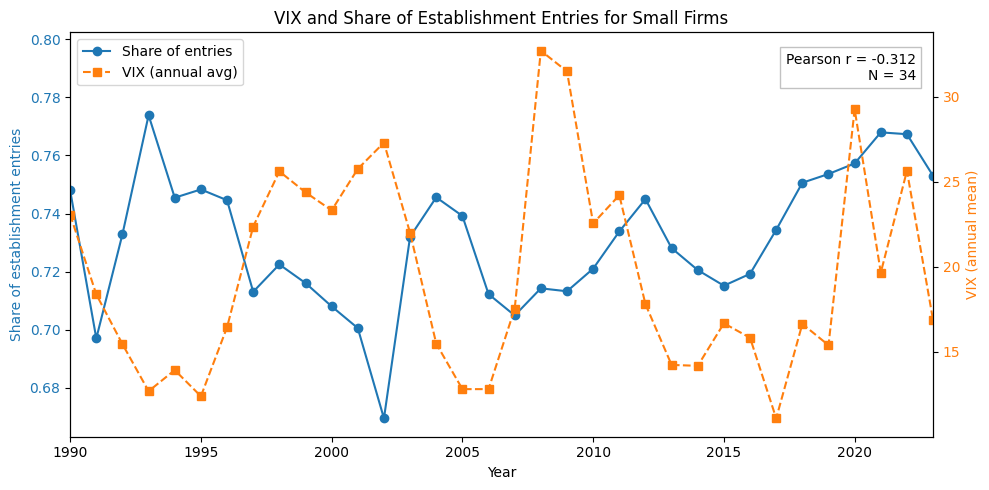

In [43]:

sel = merged_df[(merged_df['empszfi'] == '612')].copy()
sel = sel.sort_values('year')
x = sel['year'].astype(int)
y_share = sel['share'].astype(float)
y_vix = sel['vix'].astype(float)

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

ax1.plot(x, y_share, marker='o', color='C0', label='Share of entries')
ax2.plot(x, y_vix, marker='s', linestyle='--', color='C1', label='VIX (annual avg)')

ax1.set_xlabel('Year')
ax1.set_ylabel('Share of establishment entries', color='C0')
ax2.set_ylabel('VIX (annual mean)', color='C1')
ax1.set_title('VIX and Share of Establishment Entries for Small Firms')

ax1.set_xticks(x)
ax1.tick_params(axis='y', labelcolor='C0')
ax2.tick_params(axis='y', labelcolor='C1')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
# compute Pearson correlation on years with VIX and annotate the plot
mask = y_vix.notna()
n = int(mask.sum())
corr = y_share[mask].corr(y_vix[mask]) if n > 1 else float("nan")
ax1.text(
    0.98,
    0.95,
    f"Pearson r = {corr:.3f}\nN = {n}",
    transform=ax1.transAxes,
    ha="right",
    va="top",
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="0.7")
)
fig.tight_layout()
# Plot from 1990 onwards
ax1.set_xlim(1990, x.max())
# set x ticks every 5 years from 1990 to the last plotted year
start = 1990
end = int(x.max())
xticks = list(range(start, end + 1, 5))
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks)
plt.show()